# Warranty Cost Estimation

In [1]:
import pandas as pd
import datetime
import numpy as np
import reliability
from reliability.Fitters import *
from reliability.Probability_plotting import *
import matplotlib.pyplot as plt
from reliability.Distributions import *
import matplotlib.pyplot as plt
import seaborn as sns
from reliability.Other_functions import make_right_censored_data, histogram

In [2]:
reliability.__version__

'0.8.3'

In [4]:
machines = pd.read_csv("machines_test_1.csv")
machines.head()
# serial = list(machines['Serial Number'])
# serial_set = set(machines['Serial Number'])
# print(len(serial))
# print(len(serial_set))

# import collections
# print([item for item, count in collections.Counter(serial).items() if count > 1])


,Invoice Dealer Code,Serial Number,Product Line Code,Techtype Code,...,Vehicle Industry Description,Vehicle Industry Code,End Customer Name,End Customer Code
0,130000,NGAC00778,D,535211650,...,AGRICULTURE,418,1478589,1478589
1,130000,NGAC00786,D,535211650,...,AGRICULTURE,418,1478589,1478589
2,130000,NGAF05906,GR,542200130,...,NaN,#,#,#
3,130000,NGAF05915,GR,542200130,...,NaN,#,#,#
4,130000,NHAC00845,D,535221650,...,AGRICULTURE,418,1478589,1478589


In [5]:
claim = pd.read_csv("claims_test_1.csv",encoding= 'unicode_escape')
claim.head()

,Invoice Dealer Code,Repair Dealer Code,Claim Number,Serial Number,...,Paid Extra Repair Amount CCR Dollars,Paid Travel Amount CCR Dollars,Paid Handling \ Landing Amount CCR Dollars,Total Amount with Dealer Net CCR Dollars
0,140910,140833,302000012047,ZZZN0845LKAF07491,...,0,0,0,40.54054
1,140910,140838,301800093242,ZZZN2050CHAC00862,...,0,0,0,40.54054
2,140910,140334,301900045027,ZZZN2050KHAC00888,...,0,0,0,40.54054
3,140910,140335,302000140611,ZZZN0865HJAF06793,...,0,0,0,72.972972
4,140910,186949,302000427971,ZZZN0845LKAF07494,...,0,0,0,40.54054


In [5]:
cdata = pd.merge(machines,claim, on="Serial Number", how="outer" , validate = "one_to_many")
cdata.columns

Index(['Invoice Dealer Code_x', 'Serial Number', 'Product Line Code_x', 'Techtype Code_x', 'Model Key Code', 'Family Key_x', 'Engine Family Code_x', 'Engine Family Description_x',
       'Production Plant Code_x', 'Production Date_x', 'Invoice Date_x', 'Base Warranty Start Date_x', 'Extended Warranty Expire Date_x', 'End Customer Region Code', 'End Customer Postal Code',
       'End Customer City', 'Base Warranty Expire Date', 'Vehicle Industry Description', 'Vehicle Industry Code', 'End Customer Name', 'End Customer Code', 'Invoice Dealer Code_y',
       'Repair Dealer Code', 'Claim Number', 'Failure 13 Digits', 'Causal Part Code', 'Causal Part Descriprion', 'CNHi Failure Code', 'CNHi Failure Description', 'Product Component Code',
       'Product Component Description', 'Component Description', 'CNHi Component Code', 'Component Code', 'Component Description.1', 'Defect Code', 'Defect Description', 'Defect 5 Digits',
       'Product Line Code_y', 'Techtype Code_y', 'Model Key', 'Famil

In [6]:
df = cdata[['Serial Number', 'Product Line Code_x','Model Key Code', 'Family Key_x',
       'Engine Family Code_x', 'Engine Family Description_x','Warranty Type Code','Production Date_x', 'Invoice Date_x',
       'Base Warranty Start Date_x', 'Base Warranty Expire Date','Extended Warranty Expire Date_x','Failure Date','Vehicle Industry Description', 'Vehicle Industry Code',
          'Claim Number', 'Repair Started Date', 'Repair End Date',
       'Submission Date', 'Processing Date', 'Assessment Date', 'Payment Date','Component Description',
       'Years at Failure', 'Months at Failure','Worked Hours\ Mileage km','Total Amount with Dealer Net CCR Dollars']]

In [7]:
df.shape

(5548, 27)

In [8]:
df[['Invoice Date_x',
       'Base Warranty Start Date_x', 'Base Warranty Expire Date','Extended Warranty Expire Date_x','Failure Date']] = df[['Invoice Date_x',
       'Base Warranty Start Date_x', 'Base Warranty Expire Date','Extended Warranty Expire Date_x','Failure Date']].apply(pd.to_datetime)

C:\Users\t.rahul\Anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [9]:
df["Total Amount with Dealer Net CCR Dollars"] = [float(str(i).replace(",", "")) for i in df["Total Amount with Dealer Net CCR Dollars"]]

C:\Users\TE3A6~1.RAH\AppData\Local\Temp/ipykernel_12712/2288029135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Total Amount with Dealer Net CCR Dollars"] = [float(str(i).replace(",", "")) for i in df["Total Amount with Dealer Net CCR Dollars"]]


In [10]:
df['Months at Failure'] = df['Months at Failure'].replace(np.nan, 0)
df['Event'] = np.where(df['Months at Failure']==0, 0, 1)
df = df[df['Warranty Type Code']!="S"]
df.info()

C:\Users\TE3A6~1.RAH\AppData\Local\Temp/ipykernel_12712/1283137593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Months at Failure'] = df['Months at Failure'].replace(np.nan, 0)
C:\Users\TE3A6~1.RAH\AppData\Local\Temp/ipykernel_12712/1283137593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Event'] = np.where(df['Months at Failure']==0, 0, 1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2872 entries, 0 to 5547
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Serial Number                             2872 non-null   object        
 1   Product Line Code_x                       2867 non-null   object        
 2   Model Key Code                            2867 non-null   object        
 3   Family Key_x                              2867 non-null   object        
 4   Engine Family Code_x                      2867 non-null   float64       
 5   Engine Family Description_x               2867 non-null   object        
 6   Warranty Type Code                        2715 non-null   object        
 7   Production Date_x                         2643 non-null   object        
 8   Invoice Date_x                            2867 non-null   datetime64[ns]
 9   Base Warranty Start Date_x    

# 1. Actual cost of 1st year standard warranty and failure frequency for each of the 2 model families

In [11]:
from IPython.display import display, HTML
for i in ['D','GR']:
    data = df[df['Product Line Code_x']==i]
    data = data[data['Months at Failure']<=12]
    data.to_csv(f"{i}_data.csv")
    n = len(data['Serial Number'].unique())
    f = len(data)
    d = 365
    MTBF = round((n*d)/f,1)
    FR = round(1/MTBF,2)
    FF = round(f/n,0)
    TCost = round(data["Total Amount with Dealer Net CCR Dollars"].sum(),3)
    UnitCost = round(TCost/n,3)
    print('MODEL FAMILY "{}"'.format(i))
    results = pd.DataFrame({'Number of Units':[n], 'Warranty Duration':[d], 'Number of Failures':[f], 'MTBF-Mean Time Between Failure':[MTBF],
                'Failure Rate':[FR], 'Failure Frequency':[FF], 'Total Actual Cost':[TCost], 'Unit Cost':[UnitCost]})
    display(HTML(results.to_html(index=False)))
    print('\n\n')


MODEL FAMILY "D"


Number of Units,Warranty Duration,Number of Failures,MTBF-Mean Time Between Failure,Failure Rate,Failure Frequency,Total Actual Cost,Unit Cost
112,365,667,61.3,0.02,6,373305,3333.08





MODEL FAMILY "GR"


Number of Units,Warranty Duration,Number of Failures,MTBF-Mean Time Between Failure,Failure Rate,Failure Frequency,Total Actual Cost,Unit Cost
462,365,1283,131.4,0.01,3,517521,1120.18


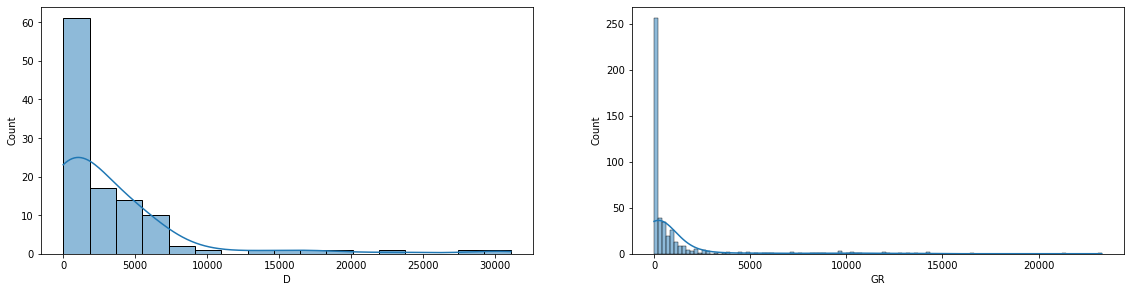

In [12]:
fig = plt.figure(figsize=(30,10))

a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

for i in ['D','GR']:
    data = df[df['Product Line Code_x']==i]
    data = data[data['Months at Failure']<12.1]
    datag = data.groupby('Serial Number').agg({'Total Amount with Dealer Net CCR Dollars': ['sum'],'Event':['sum']}).reset_index() 
    datag.columns = ["Serial Number","Cost","Failures"]
    #datag = datag[datag["Cost"]!=0]
    plt.subplot(a, b, c)
    plt.xlabel(i)
    sns.histplot(data=datag['Cost'],kde=True)
    c = c+1
plt.show()

Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 83/0 (0% right censored) 

   Distribution   Alpha     Beta   Gamma Alpha 1   Beta 1 Alpha 2      Beta 2 Proportion 1 DS      Mu   Sigma      Lambda  Log-likelihood    AICc     BIC       AD optimizer
     Weibull_CR                          4059.82 0.808457 31087.2 2.02059e+06                                                    -766.049 1540.61 1549.77 0.835194       TNC
       Gamma_3P 7043.38 0.637183 9.72963                                                                                         -774.236 1554.77 1561.73  1.19702       TNC
     Weibull_3P 3869.22 0.761332 9.72963                                                                                         -775.177 1556.66 1563.61  1.10889       TNC
     Weibull_2P 4035.05 0.821697                                                                                                 -778.111 1560.37 1565.06 0.795014       TNC
       Gamma_2P 6047.23 0.74375

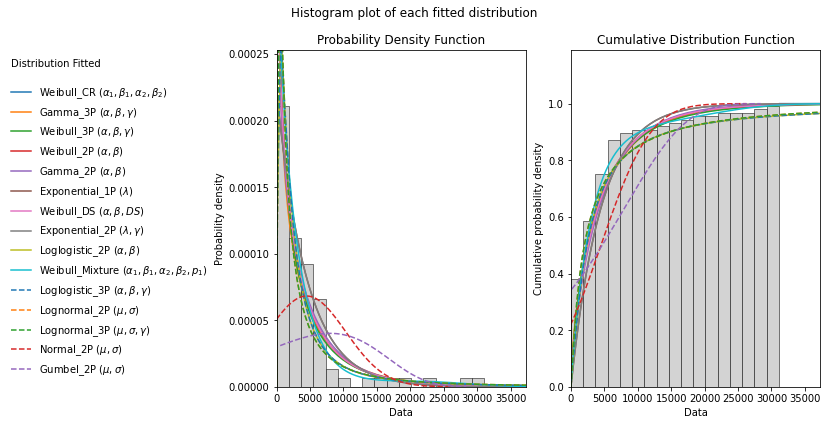

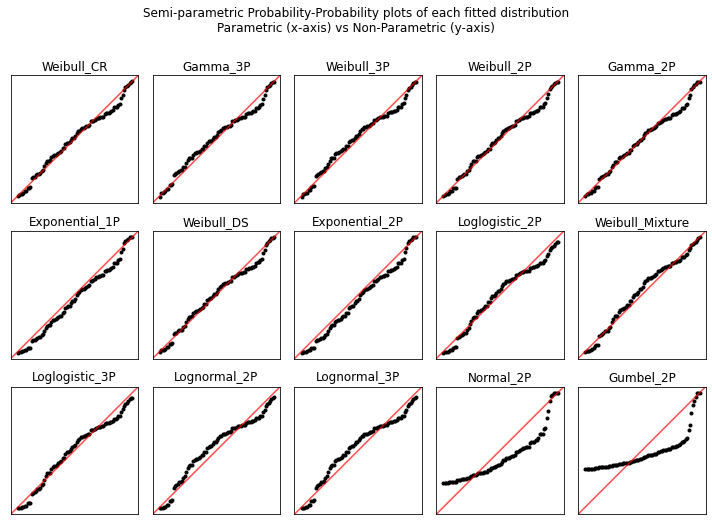

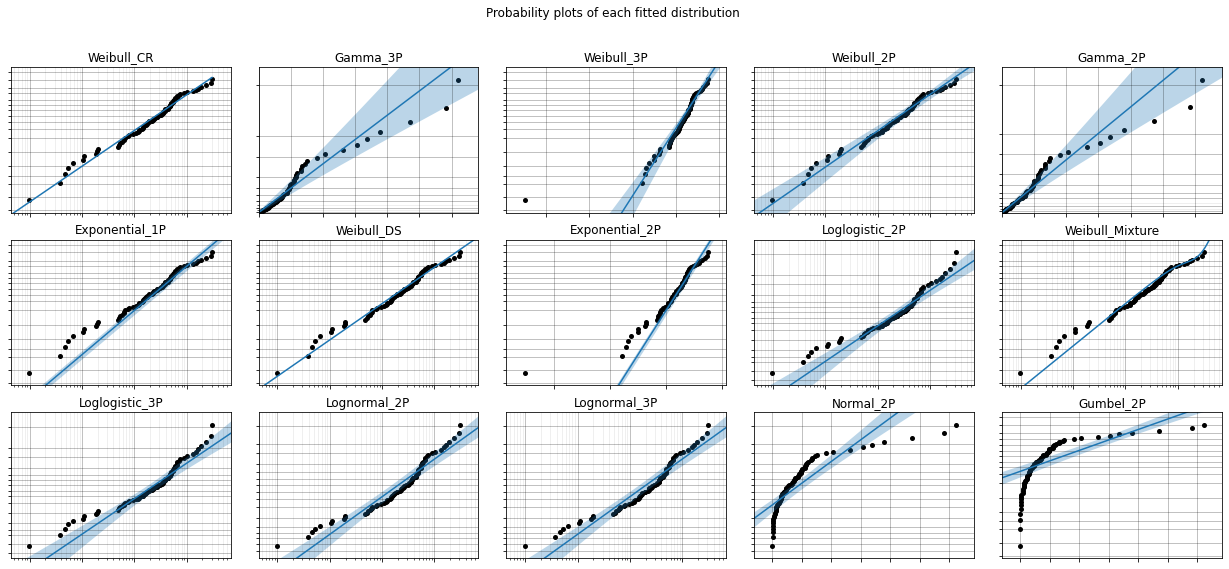

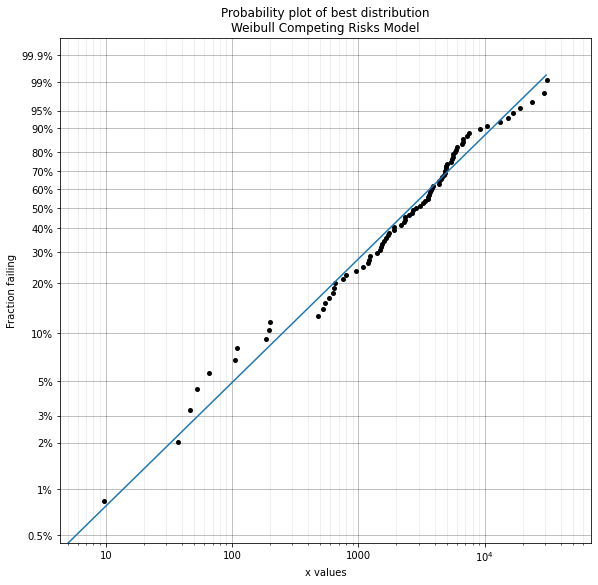

Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 334/0 (0% right censored) 

   Distribution   Alpha     Beta   Gamma Alpha 1   Beta 1 Alpha 2   Beta 2 Proportion 1 DS      Mu   Sigma      Lambda  Log-likelihood    AICc     BIC      AD optimizer
     Weibull_3P 785.898 0.518517 3.64855                                                                                      -2605.82 5217.71 5229.07 2.47097       TNC
 Loglogistic_3P 318.551 0.792374 3.64855                                                                                      -2615.23 5236.53 5247.89 1.82919       TNC
   Lognormal_2P                                                                            5.77043 1.93661                       -2622 5248.04 5255.63 1.46395       TNC
   Lognormal_3P                  2.58544                                                   5.71569 2.03242                    -2619.85 5245.77 5257.13 1.50056       TNC
       Gamma_3P 4096.06 0.377391 3.64855          

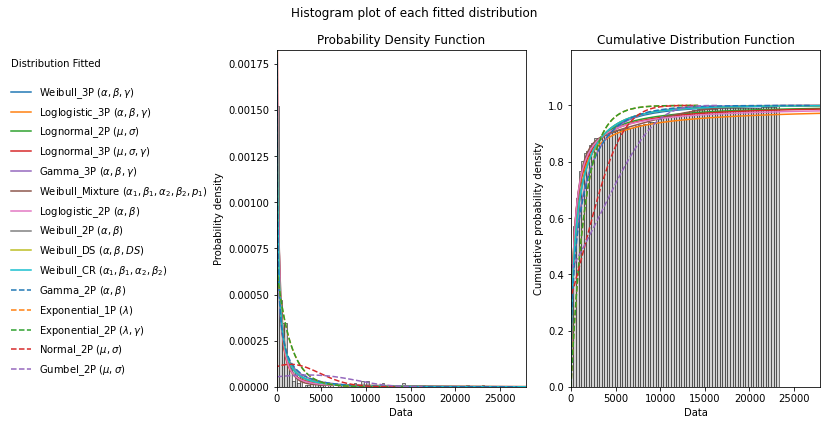

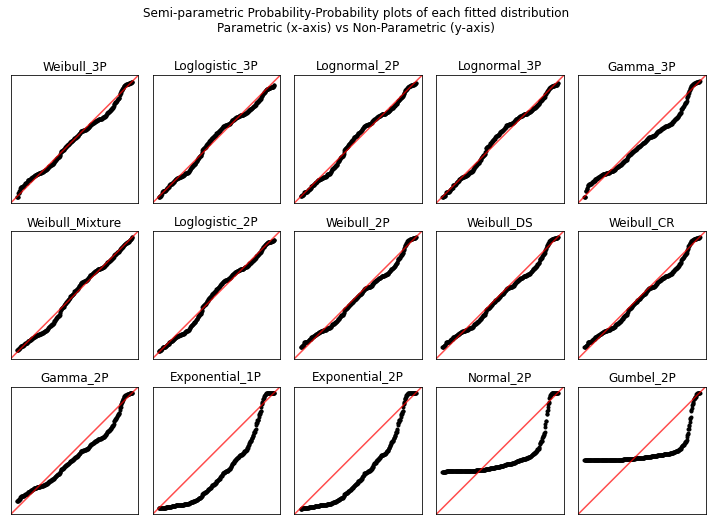

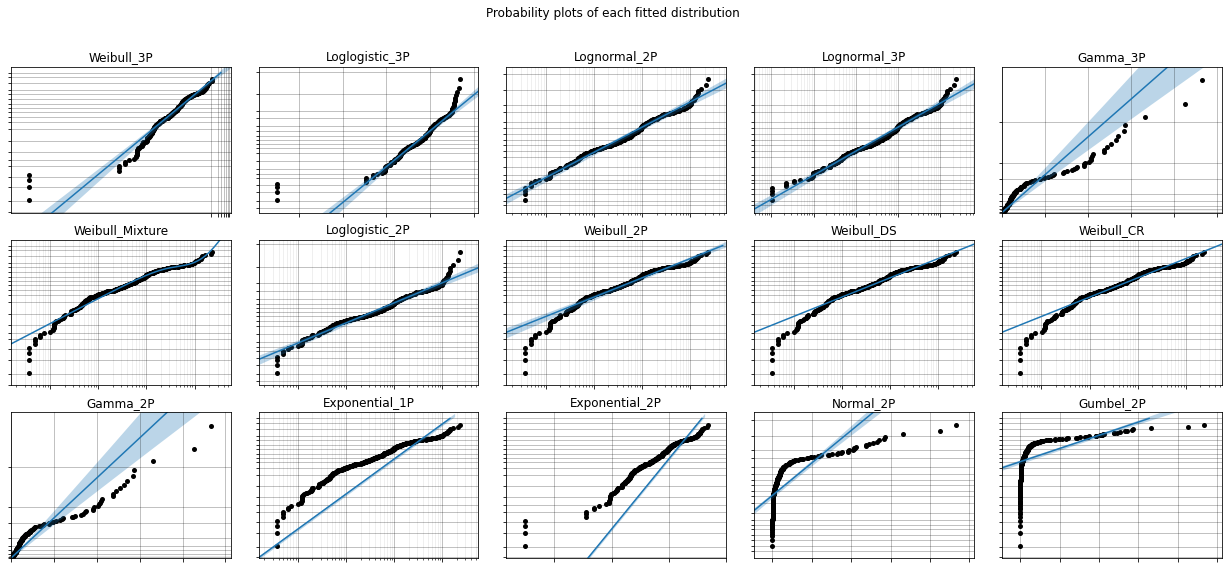

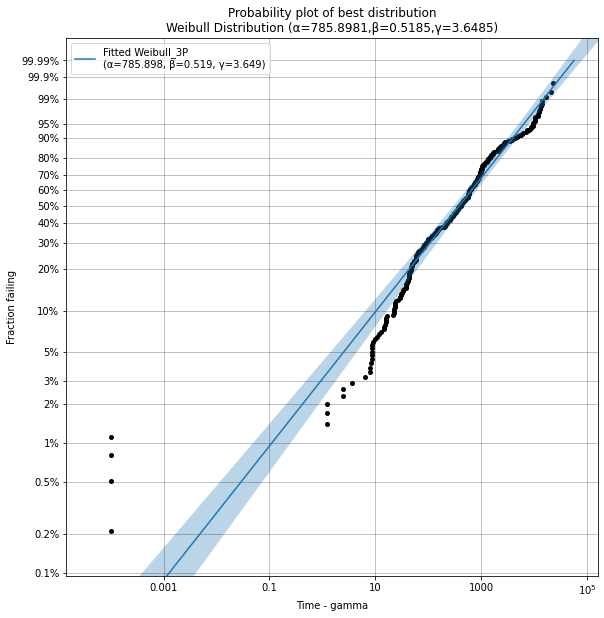

In [13]:
from IPython.display import display, HTML
ProductFamily = []
Mean = []
for i in ['D','GR']:
    data = df[df['Product Line Code_x']==i]
    data = data[data['Months at Failure']<12.1]
    datag = data.groupby('Serial Number').agg({'Total Amount with Dealer Net CCR Dollars': ['sum'],'Event':['sum']}).reset_index() 
    datag.columns = ["Serial Number","Cost","Failures"]
    fraction = len(datag[datag["Cost"]==0])/len(datag)
    datag = datag[datag["Cost"]!=0]
    data_cen = make_right_censored_data(np.array(datag['Cost']), fraction_censored=fraction, seed=0)
    output = Fit_Everything(failures=datag['Cost'].dropna().tolist())
    plot_df = (output.results)
    mean = output.best_distribution.mean
    ProductFamily.append(i)
    Mean.append(mean)

In [14]:
results = pd.DataFrame({'Product Family':ProductFamily, 'Unit Cost':Mean})
print('\n')
display(HTML(results.to_html(index=False)))
print('\n')

Product Family,Unit Cost
D,4374.5
GR,1476.69


# 2. Estimate of 2nd year cost (13 to 24 months in service) for a potential extended warranty FULL (= to standard warranty first year coverage) on a deal of 50 units for models “865” 

In [15]:
data = df[df['Model Key Code'].str.startswith('865', na=False)]
#data = data[data['Months at Failure'].between(13, 24)]
data = data[data['Months at Failure'].between(0, 24)]
data = data[~data['Months at Failure'].between(1, 12) ]
data = data[(data['Invoice Date_x'] < '2019-09-01')]
data.shape

(131, 28)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 18 to 4001
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Serial Number                             131 non-null    object        
 1   Product Line Code_x                       131 non-null    object        
 2   Model Key Code                            131 non-null    object        
 3   Family Key_x                              131 non-null    object        
 4   Engine Family Code_x                      131 non-null    float64       
 5   Engine Family Description_x               131 non-null    object        
 6   Warranty Type Code                        118 non-null    object        
 7   Production Date_x                         129 non-null    object        
 8   Invoice Date_x                            131 non-null    datetime64[ns]
 9   Base Warranty Start Date_x    

In [17]:
n = len(data['Serial Number'].unique())
f = data['Event'].sum()
d = 365
MTBF = round((n*d)/f,1)
FR = round(1/MTBF,2)
FF = round(f/n,0)
TCost = round(data["Total Amount with Dealer Net CCR Dollars"].sum(),3)
UnitCost = round(TCost/n,3)
results = pd.DataFrame({'Number of Units':[n], 'Warranty Duration':[d], 'Number of Failures':[f], 'Mean Time Between Failure':[MTBF],
                'Failure Rate':[FR], 'Failure Frequency':[FF], 'Total Actual Cost':[TCost], 'Unit Cost':[UnitCost]})
results

,Number of Units,Warranty Duration,Number of Failures,Mean Time Between Failure,Failure Rate,Failure Frequency,Total Actual Cost,Unit Cost
0,55,365,118,170.1,0.01,2,69635,1266.09


In [18]:
datag = data.groupby('Serial Number').agg({'Total Amount with Dealer Net CCR Dollars': ['sum'],'Event':['sum']}).reset_index() 
datag.columns = ["Serial Number","Cost","Failures"]
fraction = len(datag[datag["Cost"]==0])/len(datag)
# datag = datag[datag["Cost"]!=0]
data_cen = make_right_censored_data(np.array(datag['Cost']), fraction_censored=fraction, seed=0)
datag.Cost.describe()

count        55
mean    1266.09
std     3114.18
min           0
25%     26.1471
50%      260.27
75%     876.055
max     21097.5
Name: Cost, dtype: float64

In [19]:
fraction

0.23636363636363636

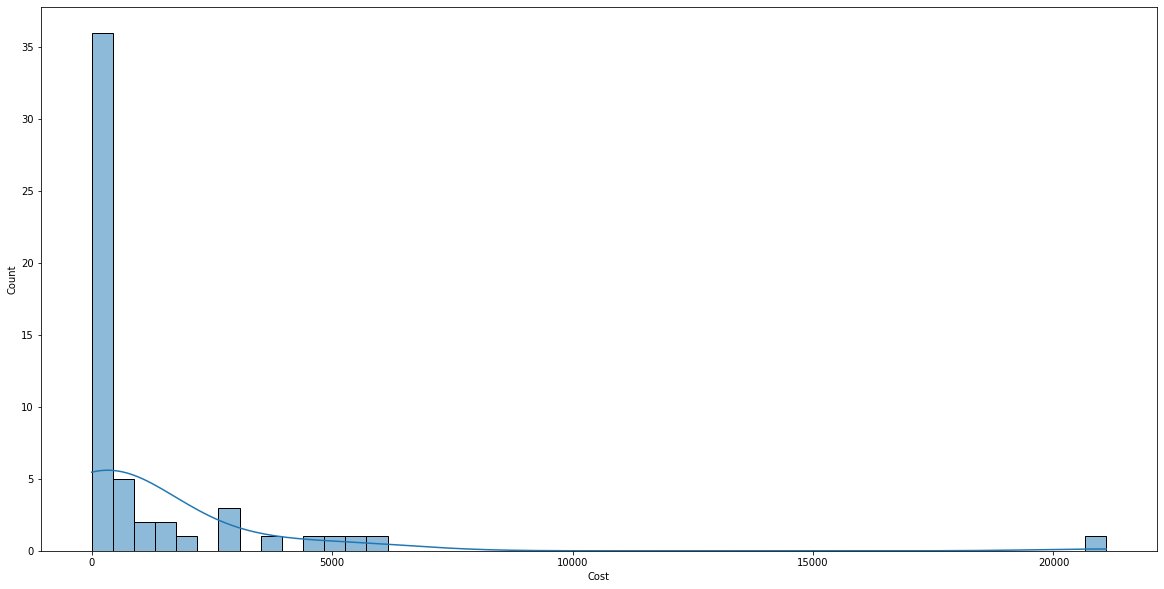

In [20]:
fig = plt.figure(figsize=(20,10))
datag = data.groupby('Serial Number').agg({'Total Amount with Dealer Net CCR Dollars': ['sum'],'Event':['sum']}).reset_index() 
datag.columns = ["Serial Number","Cost","Failures"]
# datag = datag[datag["Cost"]!=0]
sns.histplot(data=datag['Cost'],kde=True)
plt.show()

In [21]:
print(len(datag['Cost'].dropna().tolist()))

55


In [48]:
from reliability.Fitters import Fit_Weibull_2P
import matplotlib.pyplot as plt
# data = [58,75,36,52,63,65,22,17,28,64,23,40,73,45,52,36,52,60,13,55,82,55,34,57,23,42,66,35,34,25] # made using Weibull Distribution(alpha=50,beta=3)
wb = Fit_Weibull_2P(datag['Cost'].dropna().tolist(), right_censored=data_cen.right_censored, show_probability_plot=False, show_PP_plot=False)
plt.show()

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 42/9 (17.64706% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         1523.19          379.55   934.653   2482.32
     Beta         0.63343       0.0721592  0.506677  0.791892 

Goodness of fit   Value
 Log-likelihood -351.76
           AICc  707.77
            BIC 711.383
             AD 2.41319 



In [39]:
print(datag['Cost'].dropna().tolist())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 74.794054, 907.168378, 293.027431, 319.514729, 342.361756, 9.729729, 0.0, 1036.936891, 1960.309052, 4506.671216, 1604.597293, 0.0, 316.28729500000003, 602.632026, 739.187567, 661.8332419999999, 707.169188, 187.53027, 260.27027, 0.0, 21097.527836, 0.0, 2771.045672, 74.34554, 260.27027, 3534.474993, 5681.25527, 0.0, 844.941215, 6057.594593, 236.141618, 54.688781, 0.0, 1444.71054, 2828.847699, 354.09027, 294.691349, 2941.703646, 184.341755, 0.0, 303.954459, 42.564459, 73.092567, 118.223377, 5149.220267000001, 124.068918, 260.27027, 112.627702, 260.27027]


In [53]:
# wb = Fit_Weibull_2P(failures=datag['Cost'].dropna().tolist())
# plt.show()
num_list = []
def float_num(X):
    for i in X:
        i = int (i)
        num_list.append(i)
        
list_num = datag['Cost'].dropna().tolist()
X = [i for i in list_num if i != 0.0]
# print(X)
float_num(X)
print(num_list)

[74, 907, 293, 319, 342, 9, 1036, 1960, 4506, 1604, 316, 602, 739, 661, 707, 187, 260, 21097, 2771, 74, 260, 3534, 5681, 844, 6057, 236, 54, 1444, 2828, 354, 294, 2941, 184, 303, 42, 73, 118, 5149, 124, 260, 112, 260]


In [54]:
# Fit all probability distributions available from 'reliability' library
output = Fit_Everything(failures= num_list, right_censored=data_cen.right_censored)
# output = Fit_Everything(datag['Cost'].dropna().tolist())

# Define the probability distribution that best fitted the failure times for the given component
# output.best_distribution.plot()

ValueError: The minimum number of distinct failures required for a Weibull_2P distribution is 2.

In [25]:
print(output.results)

      Distribution   Alpha     Beta   Gamma  ... Log-likelihood    AICc     BIC      AD
0       Weibull_3P    1729 0.576421 9.72963  ...       -351.375 709.222 714.773 2.12481
1         Gamma_3P 4910.01 0.482157 9.72963  ...       -351.754 709.978 715.529 2.47168
5     Lognormal_2P                           ...       -354.606 713.442 717.226 1.82174
11  Loglogistic_3P 808.073 0.822556 9.72873  ...       -353.612 713.695 719.246 1.83016
10  Loglogistic_2P 830.553 0.942398          ...       -355.664 715.559 719.343 1.89985
3     Lognormal_3P                  3.88383  ...       -354.524 715.519  721.07 1.78575
7       Weibull_2P 1690.61 0.719828          ...       -357.414 719.059 722.843 2.86005
8         Gamma_2P 4699.32 0.543294          ...       -358.399 721.028 724.812 2.55736
9   Exponential_1P                           ...       -365.517  733.11 735.042 6.84284
2   Exponential_2P                  9.72963  ...       -365.275 734.781 738.565 7.14259
4        Normal_2P              

In [26]:
output.results.iloc[0][0]

'Weibull_3P'

In [27]:
dist_name = output.results.iloc[0][0]
param = output.results.iloc[0][1:7]
param.columns = ['value']
param = param.to_frame()
param.columns = ['value']
param.value = pd.to_numeric(param.value)
param.value = param.value.fillna(0)
param

,value
Alpha,1729
Beta,0.576421
Gamma,9.72963
Mu,0
Sigma,0
Lambda,0


In [90]:
if "Weibull" in dist_name:
    print("Weibull_Distribution")
    dist = Weibull_Distribution(alpha=param.iloc[0],beta=param.iloc[1],gamma=param.iloc[2])
elif "Exponential" in dist_name:
    print("Exponential_Distribution")
    dist = Exponential_Distribution(Lambda=param.iloc[5], gamma=param.iloc[2])
elif "Normal" in dist_name:
    print("Normal_Distribution")
    dist = Normal_Distribution(mu=param.iloc[3],sigma=param.iloc[4])
elif "Lognormal" in dist_name:
    print("Lognormal_Distribution")
    dist = Lognormal_Distribution(mu=param.iloc[3], sigma=param.iloc[4], gamma=param.iloc[2])
elif "Gamma" in dist_name:
    print("Gamma_Distribution")
    dist = Gamma_Distribution(alpha=param.iloc[0],beta=param.iloc[1],gamma=param.iloc[2])
elif "Beta" in dist_name:
    print("Beta_Distribution")
    dist = Beta_Distribution(alpha=param.iloc[0],beta=param.iloc[1])
elif "Loglogistic" in dist_name:
    print("Loglogistic_Distribution")
    dist = Loglogistic_Distribution(alpha=param.iloc[0],beta=param.iloc[1],gamma=param.iloc[2])
elif "Gumbel" in dist_name:
    print("Gumbel_Distribution")
    dist = Gumbel_Distribution(mu=param.iloc[3],sigma=param.iloc[4])
else:
    print("Distribution not Found!")

Distribution not Found!


In [91]:
dist_name, dist

('Alpha',
 <reliability.Distributions.Exponential_Distribution at 0x18afa260520>)

In [92]:
means = []
percentile95 = []
i = 0
while(i<100):
    sample = dist.random_samples(50)
    output = Fit_Weibull_3P(failures=sample,show_probability_plot=False,print_results=False)
    means.append(output.distribution.mean)
    percentile95.append(output.distribution.b95)
    i+=1
sim = pd.DataFrame({'means':means,'percentile95':percentile95})

In [31]:
sim

,means,percentile95
0,3774.78,17036.1
1,2846.15,11494.4
2,3176.32,13821
3,1820.8,7053.34
4,2880.78,12670.9
5,2841.48,11712.3
6,2043.1,8303.49
7,3891.13,17182.9
8,2368.23,9055.78
9,3091.89,13667.2


In [32]:
sim.means.mean()

2969.2588575550244

Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 100/0 (0% right censored) 

  Distribution   Alpha    Beta   Gamma      Mu   Sigma      Lambda  Log-likelihood    AICc     BIC       AD
      Gamma_2P 210.114 14.1316                                            -806.679 1617.48 1622.57 0.462791
  Lognormal_2P                         7.96029 0.27038                    -807.137  1618.4 1623.48 0.495424
    Weibull_3P 1891.06 2.25777 1300.34                                    -805.453 1617.16 1624.72 0.398811
     Normal_2P                         2969.26 786.296                    -808.626 1621.38 1626.46 0.822218
      Gamma_3P 214.129 13.6266 51.4016                                    -806.667 1619.58 1627.15 0.460954
Loglogistic_2P 2881.65 6.34041                                            -809.386  1622.9 1627.98 0.536933
  Lognormal_3P                       0 7.96029 0.27038                    -807.137 1620.52 1628.09 0.495424
    Weibull_2P 3271.03 4.08596 

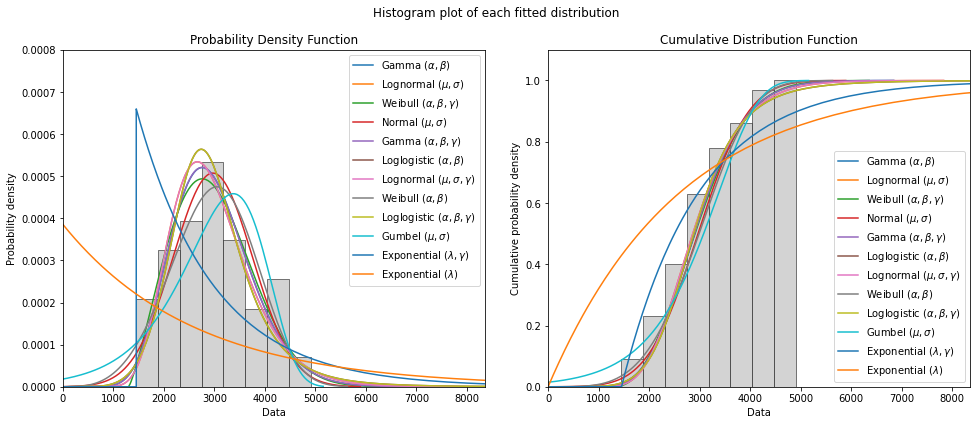

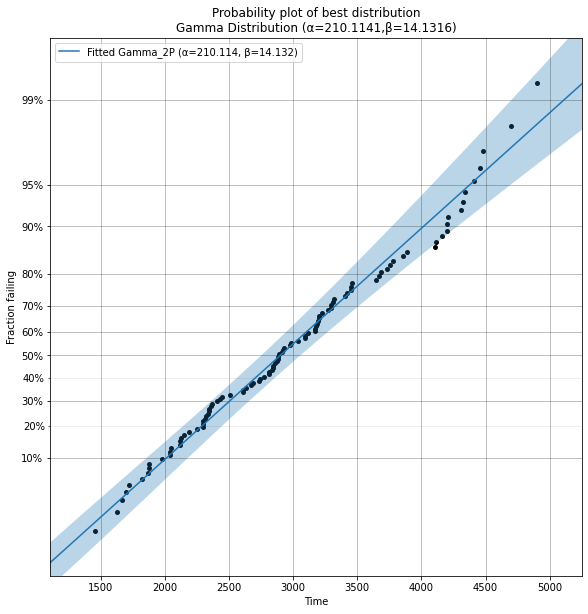

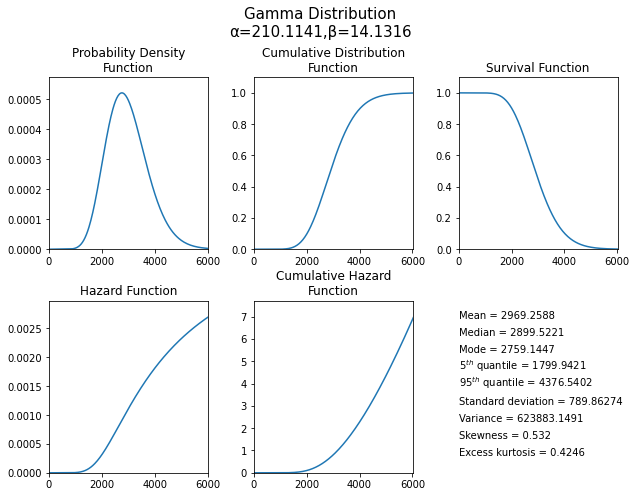

In [33]:
# Fit all probability distributions available from 'reliability' library
output = Fit_Everything(failures=sim['means'].dropna().tolist(), show_probability_plot=False, show_PP_plot=False)

# Define the probability distribution that best fitted the failure times for the given component
output.best_distribution.plot()

In [34]:
output.best_distribution.mean

2969.2587925855123

# 3. Estimate of a contract for additional 4 years (13 to 60 months in service) extended warranty FULL (= to standard warranty first year coverage) for models “2050” for both 2 units and 20 units

In [93]:
data = df[df['Model Key Code'].str.startswith('2050', na=False)]
data = data[data['Months at Failure'].between(0, 60)]
data = data[~data['Months at Failure'].between(1, 12) ]
#data = data[(data['Invoice Date_x'] < '2016-09-01')]
data.shape

(381, 28)

In [94]:
data['Months at Failure'].describe()

count       381
mean    15.7698
std     7.67418
min           0
25%        13.4
50%        16.3
75%        20.4
max        33.8
Name: Months at Failure, dtype: float64

In [95]:
n = len(data['Serial Number'].unique())
f = data['Event'].sum()
d = 4*365
MTBF = round((n*d)/f,1)
FR = round(1/MTBF,4)
FF = round(f/n,0)
TCost = round(data["Total Amount with Dealer Net CCR Dollars"].sum(),3)
UnitCost = round(TCost/n,3)
results = pd.DataFrame({'Number of Units':[n], 'Warranty Duration':[d], 'Number of Failures':[f], 'Mean Time Between Failure':[MTBF],
                'Failure Rate':[FR], 'Failure Frequency':[FF], 'Total Actual Cost':[TCost], 'Unit Cost':[UnitCost]})
results

,Number of Units,Warranty Duration,Number of Failures,Mean Time Between Failure,Failure Rate,Failure Frequency,Total Actual Cost,Unit Cost
0,79,1460,352,327.7,0.0031,4,479639,6071.38


In [96]:
datag = data.groupby('Serial Number').agg({'Total Amount with Dealer Net CCR Dollars': ['sum'],'Event':['sum']}).reset_index() 
datag.columns = ["Serial Number","Cost","Failures"]
fraction = len(datag[datag["Cost"]==0])/len(datag)
# datag = datag[datag["Cost"]!=0]
data_cen = make_right_censored_data(np.array(datag['Cost']), fraction_censored=fraction, seed=0)
datag.Cost.describe()

count        79
mean    6071.38
std     8622.38
min           0
25%           0
50%     2682.09
75%     7583.14
max     43241.7
Name: Cost, dtype: float64

In [97]:
fraction

0.26582278481012656

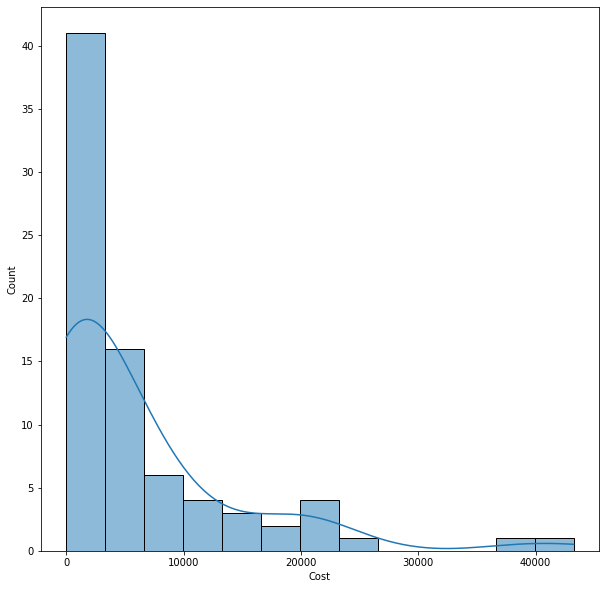

In [98]:
fig = plt.figure(figsize=(10,10))
datag = data.groupby('Serial Number').agg({'Total Amount with Dealer Net CCR Dollars': ['sum'],'Event':['sum']}).reset_index() 
datag.columns = ["Serial Number","Cost","Failures"]
#datag = datag[datag["Cost"]!=0]
sns.histplot(data=datag['Cost'],kde=True)
plt.show()

Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 58/20 (25.64103% right censored) 

  Distribution   Alpha     Beta  Gamma      Mu   Sigma      Lambda  Log-likelihood    AICc     BIC       AD
Exponential_1P                                         9.34174e-05        -596.149 1194.35 1196.65  1.08897
      Gamma_3P 12930.2 0.751971 46.918                                    -591.909 1190.14 1196.89  1.86202
    Weibull_3P 10789.4 0.778531 46.918                                    -592.795 1191.92 1198.66  1.21281
Exponential_2P                  46.918                 9.40024e-05        -595.806 1195.77 1200.33  1.26588
      Gamma_2P 12930.3 0.862543                                           -595.808 1195.78 1200.33 0.919212
    Weibull_2P 10939.9 0.930114                                           -595.908 1195.98 1200.53 0.905755
Loglogistic_2P 5850.62  1.21425                                            -599.95 1204.06 1208.61  1.46301
  Lognormal_2P          

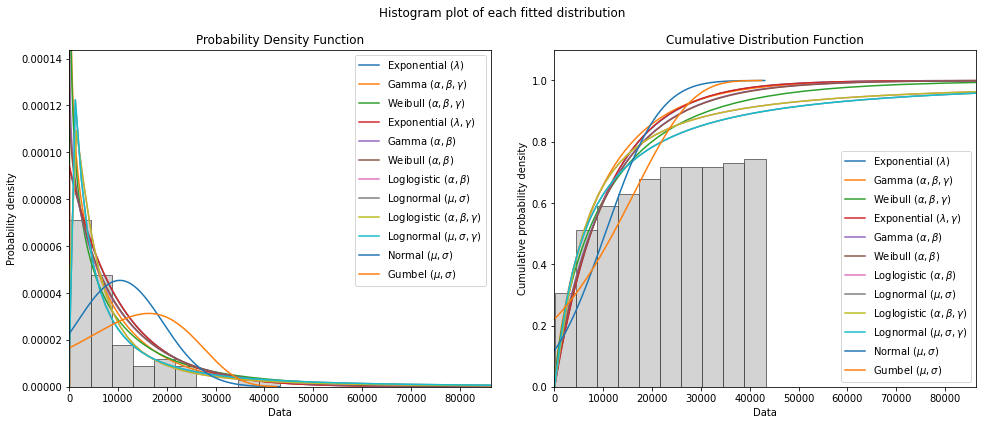

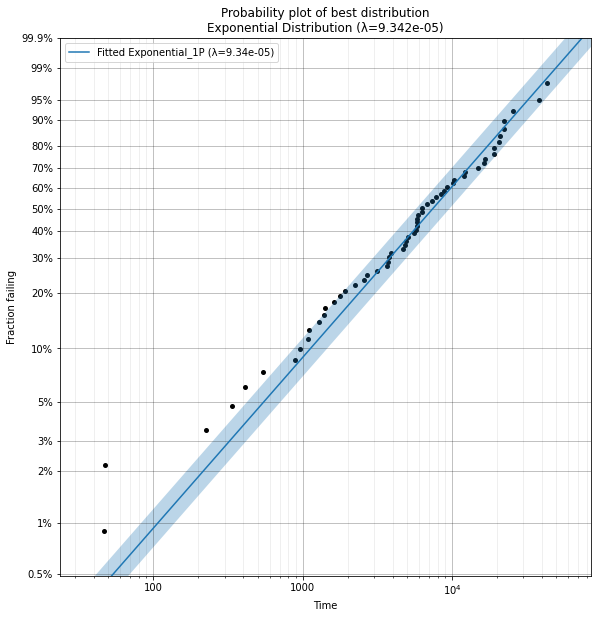

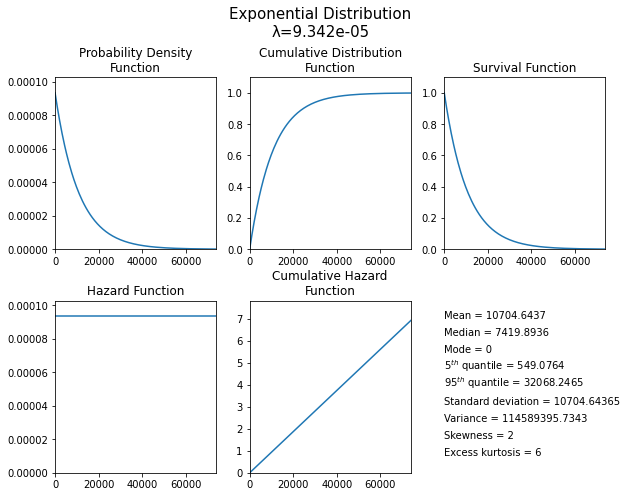

In [99]:
# Fit all probability distributions available from 'reliability' library
output = Fit_Everything(failures=datag['Cost'].dropna().tolist(), right_censored=data_cen.right_censored, show_probability_plot=False, show_PP_plot=False)

# Define the probability distribution that best fitted the failure times for the given component
output.best_distribution.plot()

In [100]:
output.results.iloc[0][0]

'Exponential_1P'

In [101]:
#dist_name = output.results.iloc[0][0]
dist_name = output.results.iloc[0][0]
param = output.results.iloc[0][1:7]
param.columns = ['value']
param = param.to_frame()
param.columns = ['value']
param.value = pd.to_numeric(param.value)
param.value = param.value.fillna(0)
param

,value
Alpha,0
Beta,0
Gamma,0
Mu,0
Sigma,0
Lambda,9.34174e-05


In [102]:
if "Weibull" in dist_name:
    print("Weibull_Distribution")
    dist = Weibull_Distribution(alpha=param.iloc[0],beta=param.iloc[1],gamma=param.iloc[2])
elif "Exponential" in dist_name:
    print("Exponential_Distribution")
    dist = Exponential_Distribution(Lambda=param.iloc[5], gamma=param.iloc[2])
elif "Normal" in dist_name:
    print("Normal_Distribution")
    dist = Normal_Distribution(mu=param.iloc[3],sigma=param.iloc[4])
elif "Lognormal" in dist_name:
    print("Lognormal_Distribution")
    dist = Lognormal_Distribution(mu=param.iloc[3], sigma=param.iloc[4], gamma=param.iloc[2])
elif "Gamma" in dist_name:
    print("Gamma_Distribution")
    dist = Gamma_Distribution(alpha=param.iloc[0],beta=param.iloc[1],gamma=param.iloc[2])
elif "Beta" in dist_name:
    print("Beta_Distribution")
    dist = Beta_Distribution(alpha=param.iloc[0],beta=param.iloc[1])
elif "Loglogistic" in dist_name:
    print("Loglogistic_Distribution")
    dist = Loglogistic_Distribution(alpha=param.iloc[0],beta=param.iloc[1],gamma=param.iloc[2])
elif "Gumbel" in dist_name:
    print("Gumbel_Distribution")
    dist = Gumbel_Distribution(mu=param.iloc[3],sigma=param.iloc[4])
else:
    print("Distribution not Found!")

Exponential_Distribution


In [103]:
dist_name, dist

('Exponential_1P',
 <reliability.Distributions.Exponential_Distribution at 0x18afab64670>)

# Deal size of 2 units

In [104]:
output.results.iloc[2][0]

'Weibull_3P'

In [105]:
output.results.iloc[2][1:7]

Alpha     10789.4
Beta     0.778531
Gamma      46.918
Mu               
Sigma            
Lambda           
Name: 0, dtype: object

In [106]:
means = []
percentile95 = []
i = 0
while(i<100):
    sample = dist.random_samples(2)
    output = Fit_Exponential_1P(failures=sample,show_probability_plot=False,print_results=False)
    means.append(output.distribution.mean)
    percentile95.append(output.distribution.b95)
    i+=1
sim = pd.DataFrame({'means':means,'percentile95':percentile95})

In [107]:
sim

,means,percentile95
0,5824.12,17447.5
1,18891.5,56593.7
2,7304.59,21882.6
3,6782,20317.1
4,10087.2,30218.4
5,30629.9,91759
6,10428.2,31240.2
7,9396.27,28148.7
8,4947.83,14822.4
9,1493.35,4473.67


In [108]:
sim.means.mean()

10006.531517676713

Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 100/0 (0% right censored) 

  Distribution   Alpha    Beta   Gamma      Mu    Sigma      Lambda  Log-likelihood    AICc     BIC       AD
      Gamma_2P 5762.76 1.72905                                             -1013.75 2031.63 2036.71 0.640379
Exponential_2P                 654.339                  0.000106923        -1014.34  2032.8 2037.88  1.62259
    Weibull_3P 9762.21 1.18918 623.954                                     -1012.29 2030.83  2038.4 0.663914
    Weibull_2P 10819.1  1.3402                                             -1014.63 2033.39 2038.47 0.792043
      Gamma_3P 6267.71 1.50282 452.429                                     -1012.71 2031.68 2039.25 0.609184
  Lognormal_2P                         8.89048 0.859202                    -1015.77 2035.66 2040.75 0.842799
Loglogistic_2P 7262.76 2.04569                                             -1016.62 2037.36 2042.45 0.805693
  Lognormal_3P         

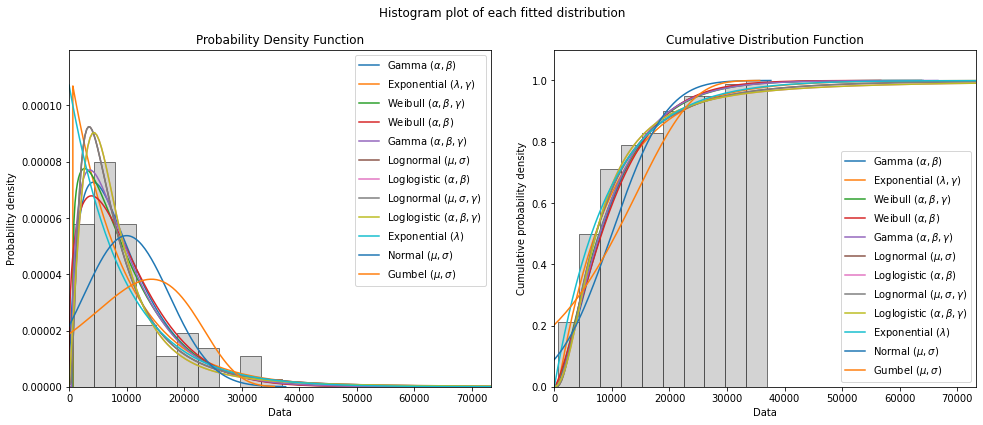

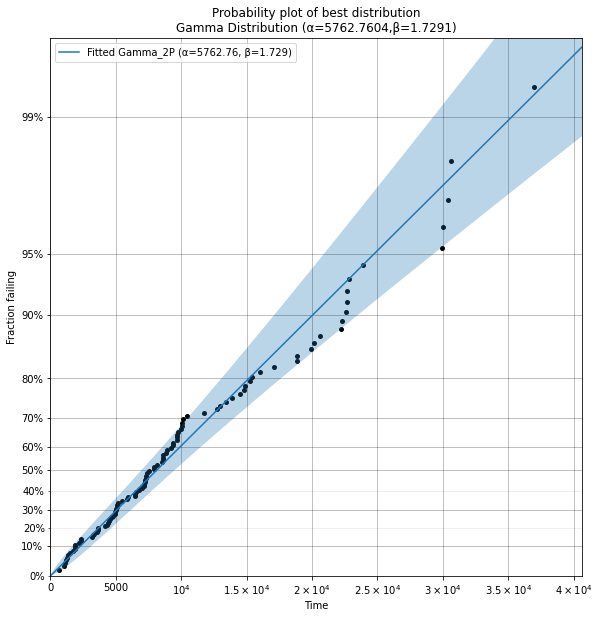

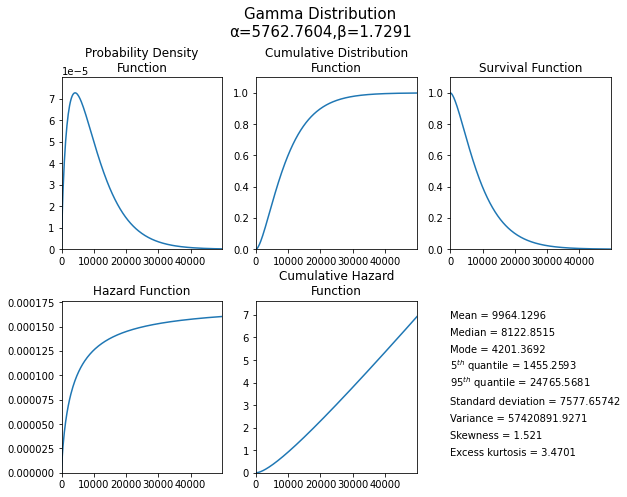

In [109]:
# Fit all probability distributions available from 'reliability' library
output1 = Fit_Everything(failures=sim['means'].dropna().tolist(), show_probability_plot=False, show_PP_plot=False)

# Define the probability distribution that best fitted the failure times for the given component
output1.best_distribution.plot()

In [110]:
output1.best_distribution.mean

9964.129605778171

# Deal size of 20 units

In [111]:
means = []
percentile95 = []
i = 0
while(i<100):
    sample = dist.random_samples(20)
    output = Fit_Gamma_3P(failures=sample,show_probability_plot=False,print_results=False)
    means.append(output.distribution.mean)
    percentile95.append(output.distribution.b95)
    i+=1
sim = pd.DataFrame({'means':means,'percentile95':percentile95})

In [112]:
sim.means.mean()

9987.578337976827

Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 100/0 (0% right censored) 

  Distribution   Alpha    Beta   Gamma      Mu    Sigma      Lambda  Log-likelihood    AICc     BIC       AD
Loglogistic_2P 9612.35 6.42595                                             -930.372 1864.87 1869.95 0.333706
  Lognormal_2P                         9.17076 0.276735                    -930.507 1865.14 1870.22 0.354251
      Gamma_2P 755.387 13.2218                                             -931.141 1866.41 1871.49 0.491494
  Lognormal_3P                       0 9.17076 0.276735                    -930.507 1867.26 1874.83 0.354251
Loglogistic_3P 7292.04 4.83427 2267.74                                     -930.649 1867.55 1875.11 0.296013
      Gamma_3P 1528.33 4.11496 3774.17                                     -932.279 1870.81 1878.37 0.678848
    Weibull_3P 6820.82 2.22732 3979.38                                     -932.538 1871.33 1878.89 0.794711
     Normal_2P         

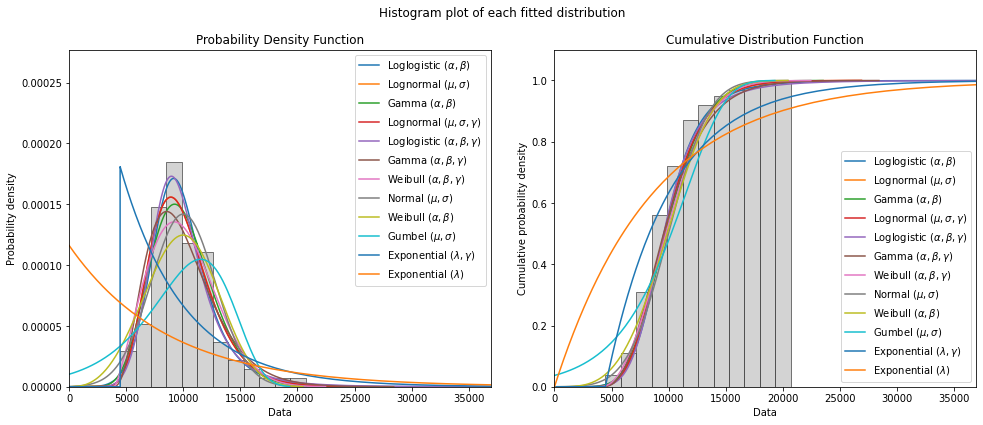

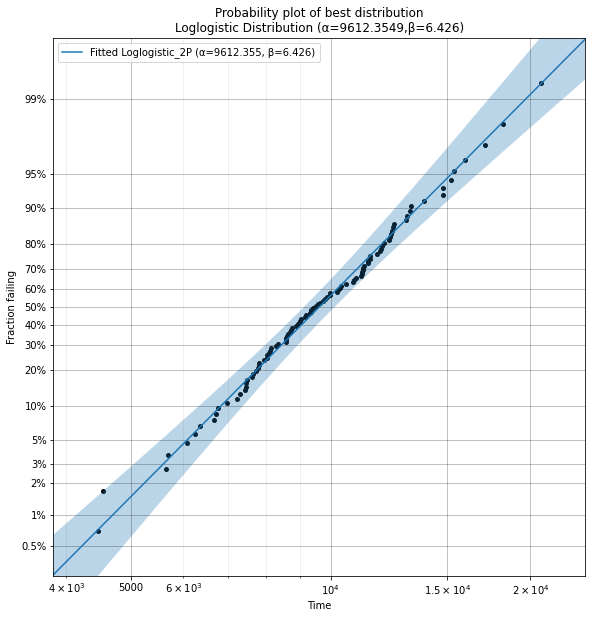

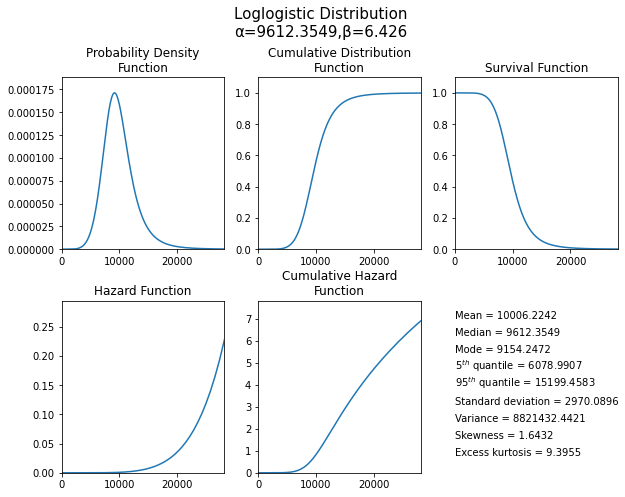

In [114]:
# Fit all probability distributions available from 'reliability' library
output2 = Fit_Everything(failures=sim['means'].dropna().tolist(), show_probability_plot=False, show_PP_plot=False)

# Define the probability distribution that best fitted the failure times for the given component
output2.best_distribution.plot()

In [115]:
output2.best_distribution.mean

10006.224191958485

# 4. Estimate of a contract for additional 4 years (13 to 60 months in service) extended warranty FULL (= to standard warranty first year coverage) for models “2050” for both 2 units and 20 units, but coverage limited to POWERTRAIN* only - Engine + Turbo + Transmission components

In [116]:
data = df[df['Model Key Code'].str.startswith('2050', na=False)]
data = data[data['Component Description'].str.contains("transmission", na=False) | data['Component Description'].str.contains("Engine", na=False) | data['Component Description'].str.contains("Turbo", na=False)]
data = data[data['Months at Failure'].between(0, 60)]
data = data[~data['Months at Failure'].between(1, 12) ]
#data = data[(data['Invoice Date_x'] < '2016-09-01')]
data.shape

(24, 28)

In [117]:
n = len(data['Serial Number'].unique())
f = data['Event'].sum()
d = 4*365
MTBF = round((n*d)/f,1)
FR = round(1/MTBF,4)
FF = round(f/n,0)
TCost = round(data["Total Amount with Dealer Net CCR Dollars"].sum(),3)
UnitCost = round(TCost/n,3)
results = pd.DataFrame({'Number of Units':[n], 'Warranty Duration':[d], 'Number of Failures':[f], 'Mean Time Between Failure':[MTBF],
                'Failure Rate':[FR], 'Failure Frequency':[FF], 'Total Actual Cost':[TCost], 'Unit Cost':[UnitCost]})
results

,Number of Units,Warranty Duration,Number of Failures,Mean Time Between Failure,Failure Rate,Failure Frequency,Total Actual Cost,Unit Cost
0,20,1460,23,1269.6,0.0008,1,114534,5726.71


In [118]:
datag = data.groupby('Serial Number').agg({'Total Amount with Dealer Net CCR Dollars': ['sum'],'Event':['sum']}).reset_index() 
datag.columns = ["Serial Number","Cost","Failures"]
datag = datag[datag["Cost"]!=0]
#data_cen = make_right_censored_data(np.array(datag['Cost']), threshold=threshold)
datag.Cost.describe()

count        20
mean    5726.71
std     5830.68
min     10.9459
25%     212.248
50%      3485.5
75%     11167.4
max     15475.4
Name: Cost, dtype: float64

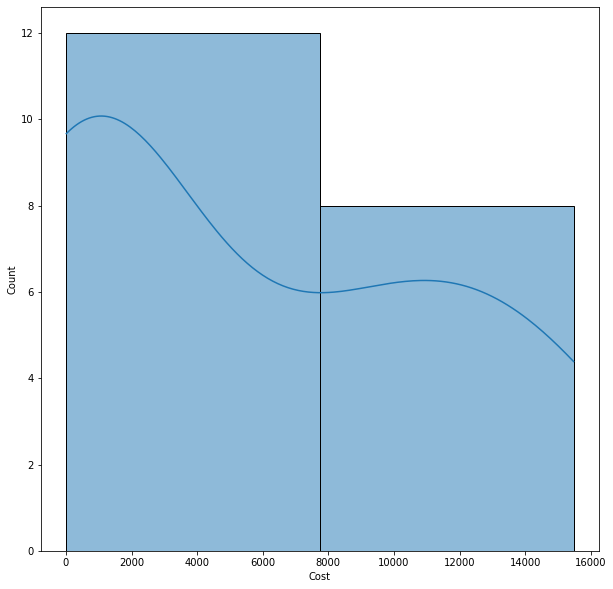

In [119]:
fig = plt.figure(figsize=(10,10))
datag = data.groupby('Serial Number').agg({'Total Amount with Dealer Net CCR Dollars': ['sum'],'Event':['sum']}).reset_index() 
datag.columns = ["Serial Number","Cost","Failures"]
#datag = datag[datag["Cost"]!=0]
sns.histplot(data=datag['Cost'],bins=2, kde=True)
plt.show()

Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 20/0 (0% right censored) 

  Distribution   Alpha     Beta   Gamma      Mu   Sigma      Lambda  Log-likelihood    AICc     BIC      AD
      Gamma_3P 28186.4  0.28373 10.9458                                    -178.897 365.294 366.781 1.28709
    Weibull_3P 5079.56 0.447413 10.9458                                    -181.337 370.174 371.661 1.20985
Loglogistic_3P 1777.15 0.519953 10.9458                                    -185.062 377.623  379.11 1.39829
    Weibull_2P 4014.49 0.567979                                            -187.725 380.155 381.441 1.63895
      Gamma_2P 26058.5   0.3492                                            -187.729 380.163 381.449 1.06469
  Lognormal_3P                  10.9458 6.53431  4.2742                    -188.117 383.734 385.221 2.26016
  Lognormal_2P                          7.18963 2.41446                    -189.801 384.307 385.593 1.73289
Loglogistic_2P 1325.61 0.719403 

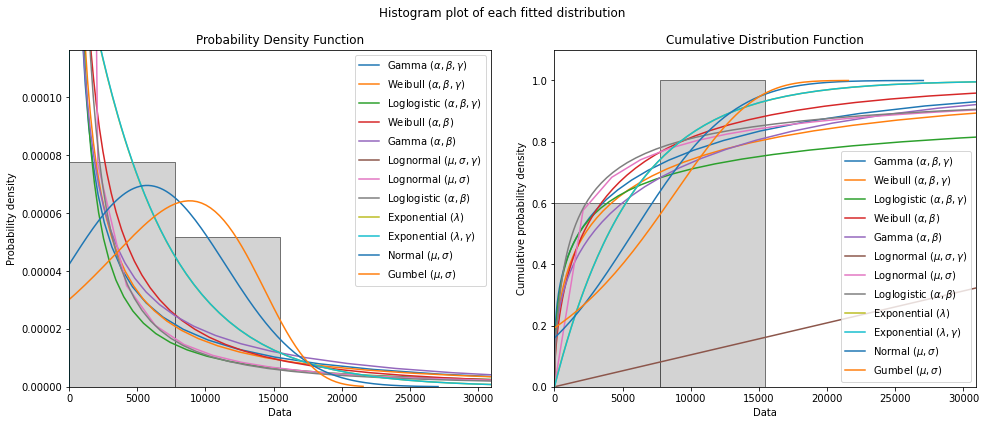

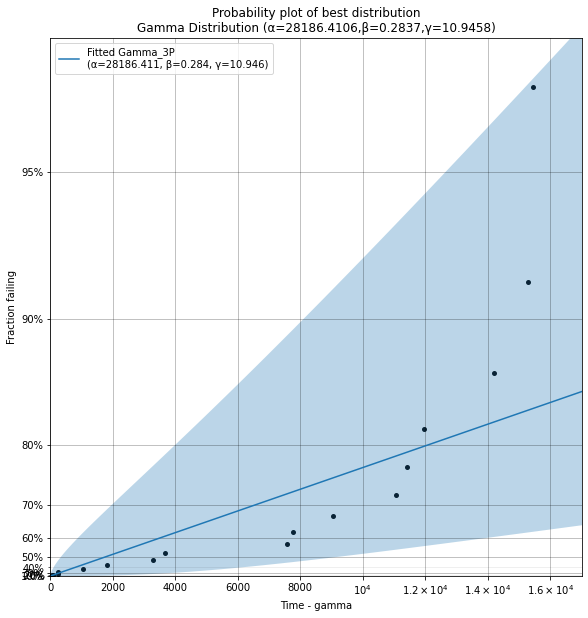

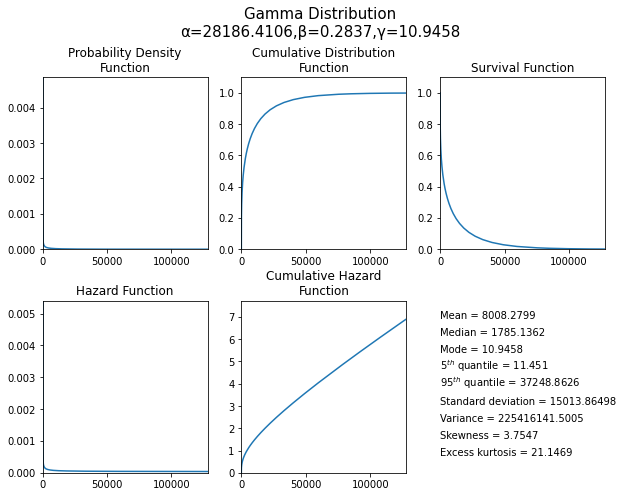

In [120]:
# Fit all probability distributions available from 'reliability' library
output = Fit_Everything(failures=datag['Cost'].dropna().tolist(), show_probability_plot=False, show_PP_plot=False)


# Define the probability distribution that best fitted the failure times for the given component
output.best_distribution.plot()

In [121]:
dist_name = output.results.iloc[0][0]
param = output.results.iloc[0][1:7]
param.columns = ['value']
param = param.to_frame()
param.columns = ['value']
param.value = pd.to_numeric(param.value)
param.value = param.value.fillna(0)
param

,value
Alpha,28186.4
Beta,0.28373
Gamma,10.9458
Mu,0
Sigma,0
Lambda,0


In [74]:
if "Weibull" in dist_name:
    print("Weibull_Distribution")
    dist = Weibull_Distribution(alpha=param.iloc[0],beta=param.iloc[1],gamma=param.iloc[2])
elif "Exponential" in dist_name:
    print("Exponential_Distribution")
    dist = Exponential_Distribution(Lambda=param.iloc[5], gamma=param.iloc[2])
elif "Normal" in dist_name:
    print("Normal_Distribution")
    dist = Normal_Distribution(mu=param.iloc[3],sigma=param.iloc[4])
elif "Lognormal" in dist_name:
    print("Lognormal_Distribution")
    dist = Lognormal_Distribution(mu=param.iloc[3], sigma=param.iloc[4], gamma=param.iloc[2])
elif "Gamma" in dist_name:
    print("Gamma_Distribution")
    dist = Gamma_Distribution(alpha=param.iloc[0],beta=param.iloc[1],gamma=param.iloc[2])
elif "Beta" in dist_name:
    print("Beta_Distribution")
    dist = Beta_Distribution(alpha=param.iloc[0],beta=param.iloc[1])
elif "Loglogistic" in dist_name:
    print("Loglogistic_Distribution")
    dist = Loglogistic_Distribution(alpha=param.iloc[0],beta=param.iloc[1],gamma=param.iloc[2])
elif "Gumbel" in dist_name:
    print("Gumbel_Distribution")
    dist = Gumbel_Distribution(mu=param.iloc[3],sigma=param.iloc[4])
else:
    print("Distribution not Found!")

Gamma_Distribution


In [75]:
dist_name, dist

('Gamma_3P', <reliability.Distributions.Gamma_Distribution at 0x18db0f4ad90>)

# Deal size of 2 units

In [122]:
output.results.iloc[3][0]

'Weibull_2P'

In [123]:
output.results.iloc[3][1:7]

Alpha     4014.49
Beta     0.567979
Gamma            
Mu               
Sigma            
Lambda           
Name: 7, dtype: object

In [124]:
means = []
percentile95 = []
i = 0
while(i<100):
    sample = Weibull_Distribution(alpha=4014.49,beta=0.567979,gamma=0).random_samples(2)
    output_fit = Fit_Weibull_2P(failures=sample,show_probability_plot=False,print_results=False)
    means.append(output_fit.distribution.mean)
    percentile95.append(output_fit.distribution.b95)
    i+=1
sim = pd.DataFrame({'means':means,'percentile95':percentile95})

In [125]:
sim

,means,percentile95
0,10427.5,39214.8
1,14892.5,54373.9
2,27454.4,97888.1
3,494.831,684.152
4,5485.77,17564.9
5,1500.41,2107.14
6,56952,206699
7,662.801,1115.28
8,741.033,1121.66
9,523.745,1624.22


In [126]:
sim.means.mean()

9489.833727688905

Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 100/0 (0% right censored) 

  Distribution   Alpha     Beta   Gamma      Mu   Sigma      Lambda  Log-likelihood    AICc     BIC       AD
      Gamma_3P 12136.4 0.673986 143.519                                    -1004.51 2015.28 2022.84 0.714584
    Weibull_3P 7658.62 0.787755 119.596                                    -1007.65 2021.54 2029.11 0.414875
  Lognormal_2P                          8.35016 1.39406                    -1010.13 2024.39 2029.47 0.739983
    Weibull_2P 8107.27 0.873206                                            -1011.86 2027.84 2032.93 0.702849
Loglogistic_2P 4230.84  1.23843                                            -1011.99 2028.11 2033.19  0.81596
  Lognormal_3P                        0 8.35016 1.39406                    -1010.13 2026.51 2034.08 0.739983
      Gamma_2P 11141.1 0.798597                                            -1012.86 2029.84 2034.93 0.816326
Loglogistic_3P  4647.4 

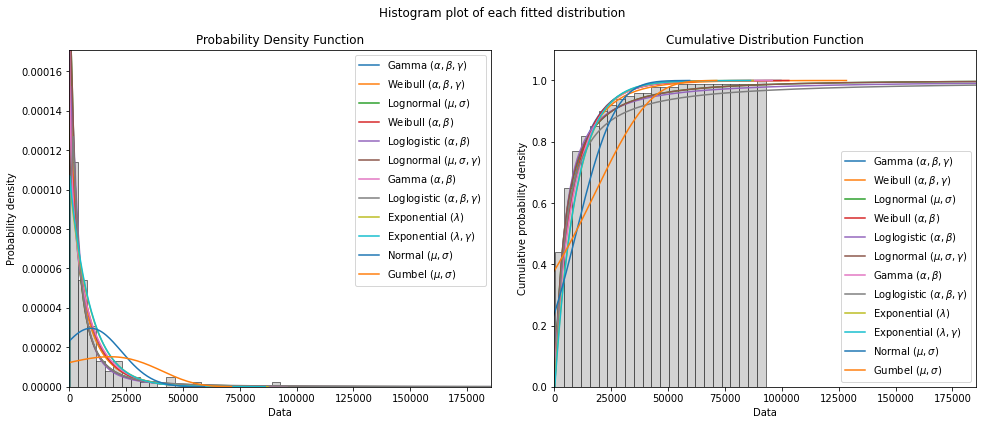

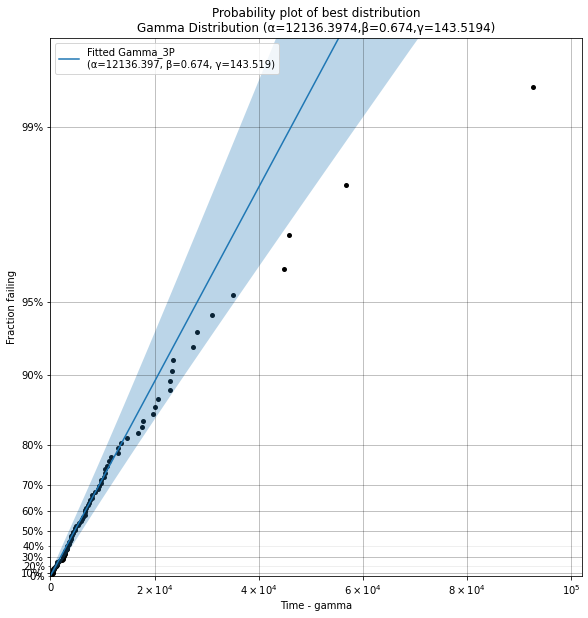

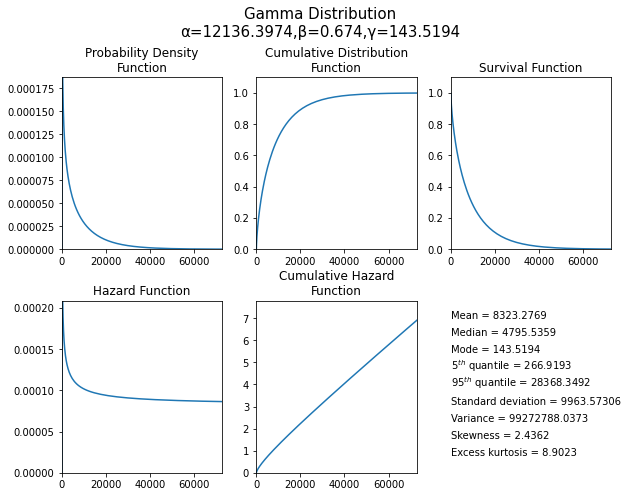

In [127]:
# Fit all probability distributions available from 'reliability' library
output3 = Fit_Everything(failures=sim['means'].dropna().tolist(), show_probability_plot=False, show_PP_plot=False)

# Define the probability distribution that best fitted the failure times for the given component
output3.best_distribution.plot()

In [128]:
output3.best_distribution.mean

8323.276915147382

# Deal size of 20 units

In [129]:
dist_name = output.results.iloc[0][0]
param = output.results.iloc[0][1:7]
param.columns = ['value']
param = param.to_frame()
param.columns = ['value']
param.value = pd.to_numeric(param.value)
param.value = param.value.fillna(0)
param

,value
Alpha,28186.4
Beta,0.28373
Gamma,10.9458
Mu,0
Sigma,0
Lambda,0


In [130]:
if "Weibull" in dist_name:
    print("Weibull_Distribution")
    dist = Weibull_Distribution(alpha=param.iloc[0],beta=param.iloc[1],gamma=param.iloc[2])
elif "Exponential" in dist_name:
    print("Exponential_Distribution")
    dist = Exponential_Distribution(Lambda=param.iloc[5], gamma=param.iloc[2])
elif "Normal" in dist_name:
    print("Normal_Distribution")
    dist = Normal_Distribution(mu=param.iloc[3],sigma=param.iloc[4])
elif "Lognormal" in dist_name:
    print("Lognormal_Distribution")
    dist = Lognormal_Distribution(mu=param.iloc[3], sigma=param.iloc[4], gamma=param.iloc[2])
elif "Gamma" in dist_name:
    print("Gamma_Distribution")
    dist = Gamma_Distribution(alpha=param.iloc[0],beta=param.iloc[1],gamma=param.iloc[2])
elif "Beta" in dist_name:
    print("Beta_Distribution")
    dist = Beta_Distribution(alpha=param.iloc[0],beta=param.iloc[1])
elif "Loglogistic" in dist_name:
    print("Loglogistic_Distribution")
    dist = Loglogistic_Distribution(alpha=param.iloc[0],beta=param.iloc[1],gamma=param.iloc[2])
elif "Gumbel" in dist_name:
    print("Gumbel_Distribution")
    dist = Gumbel_Distribution(mu=param.iloc[3],sigma=param.iloc[4])
else:
    print("Distribution not Found!")

Gamma_Distribution


In [131]:
dist_name,dist

('Gamma_3P', <reliability.Distributions.Gamma_Distribution at 0x18afa7105b0>)

In [132]:
means = []
percentile95 = []
i = 0
while(i<100):
    sample = dist.random_samples(20)
    output = Fit_Gamma_3P(failures=sample,show_probability_plot=False,print_results=False)
    means.append(output.distribution.mean)
    percentile95.append(output.distribution.b95)
    i+=1
sim = pd.DataFrame({'means':means,'percentile95':percentile95})

In [61]:
sim

,means,percentile95
0,11558.8,43335.9
1,8963.85,30941.1
2,10702,33087.4
3,8890.41,36746.2
4,9290.71,26447.4
5,8884.44,32697
6,8494.4,32693.5
7,10147.2,34512
8,11080.3,32702.4
9,16246,61634.1


In [62]:
sim.means.mean()

9445.41738956408

Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 100/0 (0% right censored) 

  Distribution   Alpha    Beta   Gamma      Mu    Sigma      Lambda  Log-likelihood    AICc     BIC       AD
  Lognormal_2P                         8.87412 0.500572                    -960.111 1924.35 1929.43 0.424605
      Gamma_2P 1902.47 4.24447                                             -960.937    1926 1931.08 0.440991
Loglogistic_2P 7144.68  3.5045                                              -961.02 1926.16 1931.25 0.420373
  Lognormal_3P                       0 8.87412 0.500572                    -960.111 1926.47 1934.04 0.424605
      Gamma_3P 1931.39 4.16688 35.7296                                     -960.904 1928.06 1935.62 0.439025
Loglogistic_3P 7144.68  3.5045       0                                      -961.02 1928.29 1935.86 0.420373
    Weibull_3P    7161 1.66067 1492.89                                      -961.07 1928.39 1935.96 0.730835
    Weibull_2P 9034.35 

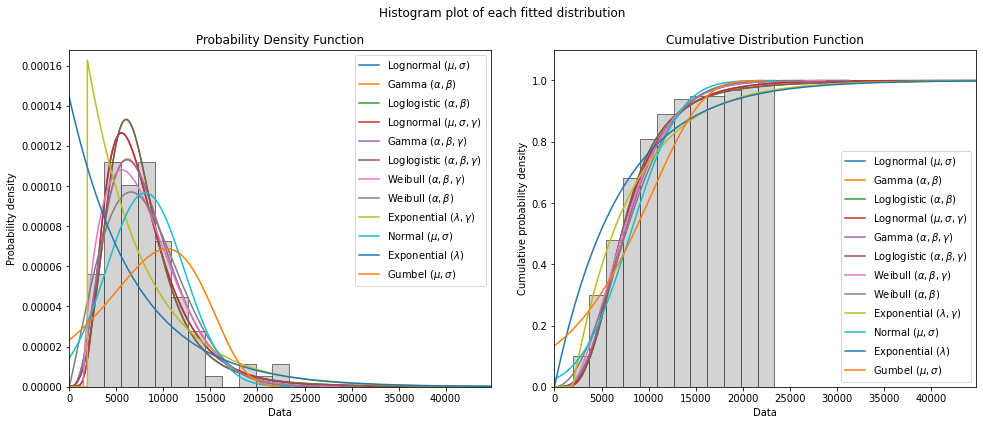

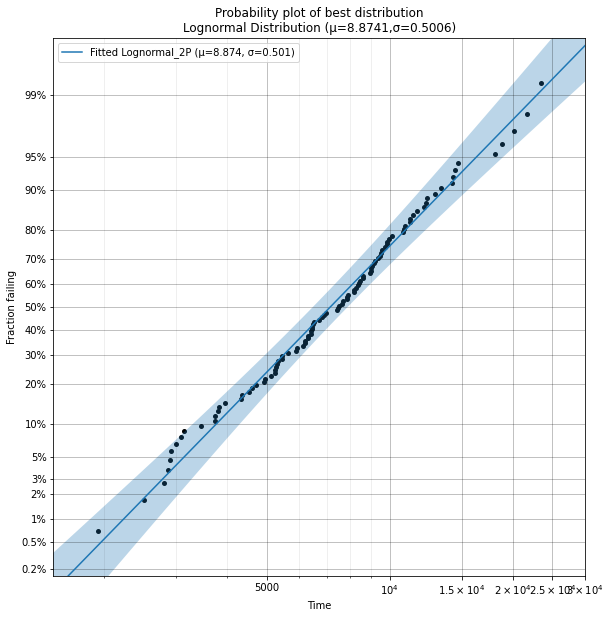

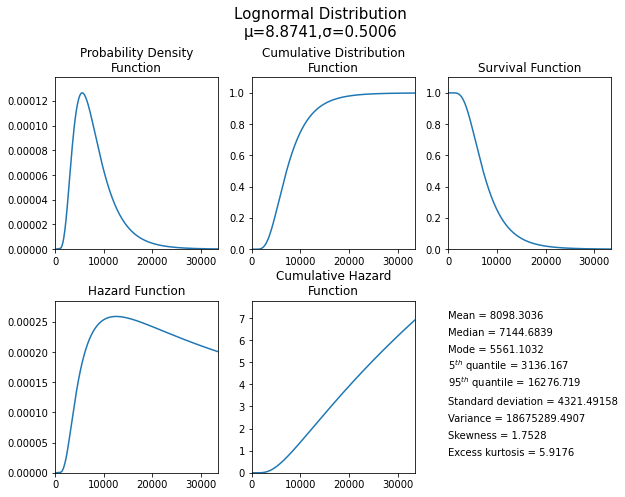

In [133]:
# Fit all probability distributions available from 'reliability' library
output = Fit_Everything(failures=sim['means'].dropna().tolist(), show_probability_plot=False, show_PP_plot=False)

# Define the probability distribution that best fitted the failure times for the given component
output.best_distribution.plot()

In [64]:
output.best_distribution.mean

9445.421746916709

# 1. Actual cost of 1st year standard warranty and failure frequency for each of the 2 model families

MODEL FAMILY "D"

Unit Cost - $3333.08

Failure Frequency - 6




MODEL FAMILY "GR"

Unit Cost - $1120.18

Failure Frequency - 3


# 2. Estimate of 2nd year cost (13 to 24 months in service) for a potential extended warranty FULL (= to standard warranty first year coverage) on a deal of 50 units for model "865"

Extended Warranty Estimates of 50 units - $2123.59

# 3. Estimate of a contract for additional 4 years (13 to 60 months in service) extended warranty FULL (= to standard warranty first year coverage) for models “2050” for both 2 units and 20 units

Extended Warranty Estimates of 2 units - $11736.94

Extended Warranty Estimates of 20 units - $9196.46

# 4. Estimate of a contract for additional 4 years (13 to 60 months in service) extended warranty FULL (= to standard warranty first year coverage) for models “2050” for both 2 units and 20 units, but coverage limited to POWERTRAIN* only - Engine + Turbo + Transmission components

Extended Warranty Estimates of 2 units - $8896.61

Extended Warranty Estimates of 20 units - $8548.73